In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [740]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
import shutil
from decode_fish.funcs.visualization import *

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.matching import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [5]:
bench_df = get_mop_benchmark()
codebook, targets = get_mop_codebook()
artifact_coords = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/artifact_coords.csv')

17130008


In [124]:
!ls -lh '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/MERFISH/sweep_mop_33/'

total 218M
-rw-r--r-- 1 speisera turaga 55M Jun 17 16:52 image_path:scaled4_images150_150.csv
-rw-r--r-- 1 speisera turaga 811 Jun 17 16:52 image_path:scaled4_images150_150.pt
-rw-r--r-- 1 speisera turaga 55M Jun 17 16:43 image_path:scaled4_images151_151.csv
-rw-r--r-- 1 speisera turaga 811 Jun 17 16:43 image_path:scaled4_images151_151.pt
-rw-r--r-- 1 speisera turaga 71M Jun 17 16:43 image_path:scaled4_images47_47.csv
-rw-r--r-- 1 speisera turaga 811 Jun 17 16:43 image_path:scaled4_images47_47.pt


In [826]:
select = ['base']#,'bs:20xcrop_sz:56xbl_loss_scale:0.003','crop_sz:56','bs:15','bs:20']

sweep_name = 'sweep_mop_35'
file_nrs = [150,151,47]
scale_train = True

model_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/MERFISH/{sweep_name}/'
Path(out_dir).mkdir(exist_ok=True)

files = glob.glob(model_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for nr in file_nrs:
        for n in files:
            if '' in n:
                name = n.split('/')[-1]
                if 'step' not in name:
                    print(name)
                    f.write(base_str + f'run_name={name} sweep_name={sweep_name}  file_nr={nr} scale_train={scale_train} \n')
#                     print(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} scale_train={scale_train} \n')

image_path:scaled4_images150
no_ch_shift
image_path:scaled4_images47
image_path:scaled4_images151
l1_fix
no_psf_vol
no_col_shifts
sl_no_lean
image_path:scaled4_images150
no_ch_shift
image_path:scaled4_images47
image_path:scaled4_images151
l1_fix
no_psf_vol
no_col_shifts
sl_no_lean
image_path:scaled4_images150
no_ch_shift
image_path:scaled4_images47
image_path:scaled4_images151
l1_fix
no_psf_vol
no_col_shifts
sl_no_lean


In [768]:
# istd_dfs = {}
# bench_dfs = {}
# for fnr in file_nrs:
#     istd_dfs[str(fnr)] = clean_istd_df(pd.read_csv(f'../data/results/MERFISH/MOp_istdeco/sweep_mop_35_norm_{fnr}.csv'), fids=artifact_coords)
#     bench_dfs[str(fnr)] = clean_bench_df(get_mop_fov(bench_df, fnr), artifact_coords)

In [743]:
from decode_fish.funcs.merfish_codenet import code_net, conv_net, input_from_df
# res_single.to_csv('data/qual_nets/starfish_test.csv')
met_net = torch.load('../data/qual_nets/net1.pkz')
# res_single['net_score'] = torch.sigmoid(met_net(input_from_df(res_single, codebook)).detach().cpu())

In [823]:
f'../data/results/MERFISH/{sweep_name}_notm/'

'../data/results/MERFISH/sweep_mop_36_notm/'

In [837]:
df_dict = {'150':{},'151':{},'47':{}}

sweep_name = 'sweep_mop_35'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}/*.csv'):
    if '' in f:
        dec_df = pd.read_csv(f)
        
        if len(dec_df) > 1000:

            if '_47' in f:
                ds = '47'
            if '_150' in f:
                ds = '150'
            if '_151' in f:
                ds = '151'

            sel = dec_df['code_inds']<len(codebook)
            print(f, sum(sel), len(dec_df)/sum(sel))
            dec_df = dec_df[sel]
            
            pred_zeroed = zero_int_ch(dec_df, codebook)
            dec_df['int_ratio'] = pred_zeroed['int_ratio'].values
            dec_df['tot_int'] = pred_zeroed['tot_int'].values
            dec_df['tot_int_0bit'] = pred_zeroed['tot_int_0bit'].values
            dec_df['tot_int_sig'] = pred_zeroed['tot_int_sig'].values
            
#             dec_df['net_score'] = torch.sigmoid(met_net(input_from_df(dec_df, codebook)).detach().cpu())
            dec_df['gene'] = 'single'
            dec_df.loc[sel,'gene'] = targets[dec_df.loc[sel,'code_inds']]
            dec_df['class'] = dec_df['gene'].str.contains('Blank').values * 1 
            name = f.split(sweep_name)[-1].split('.csv')[0]
            name = ('_').join(name.split('_')[:-1])[1:]
#             print(f.split(sweep_name)[-1].split('.csv')[0].split('_')[0][1:])
            df_dict[ds][name] = dec_df

../data/results/MERFISH/sweep_mop_35/sl_no_lean_150.csv 40001 2.762105947351316
../data/results/MERFISH/sweep_mop_35/sl_no_lean_151.csv 67280 2.330558858501784
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images150_47.csv 153342 1.4878963362940356
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images47_47.csv 92616 1.5266908525524747
../data/results/MERFISH/sweep_mop_35/no_ch_shift_150.csv 48062 2.31486413382714
../data/results/MERFISH/sweep_mop_35/l1_fix_151.csv 78477 2.067051492794067
../data/results/MERFISH/sweep_mop_35/sl_no_lean_47.csv 124154 1.6217359086296053
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images151_151.csv 53971 2.0211965685275426
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images150_150.csv 51001 2.242132507205741
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images151_150.csv 59977 2.2391583440318787
../data/results/MERFISH/sweep_mop_35/image_path:scaled4_images47_151.csv 63096 2.165794979079498
../data/result

In [838]:
names = [k for k in df_dict['47'].keys()]

omega_df = DF(columns=pd.MultiIndex.from_product([['150','151','47'], names+['bench','istdeco']]), index=['N', 'NN', 'N_blanks', 'NN_blanks', 'int_sig'])
for n in ['150','151','47']:
    omega_df.loc['N', n]['bench'] = len(bench_dfs[n])
    omega_df.loc['NN', n]['bench'] = len(bench_dfs[n])
    omega_df.loc['N_blanks', n]['bench'] = sum(bench_dfs[n]['class'])
    omega_df.loc['NN_blanks', n]['bench'] = 1.
    
    omega_df.loc['N_blanks', n]['istdeco'] = sum(istd_dfs[n].nlargest(omega_df.loc['N', n]['bench'], 'quality')['class'])
    omega_df.loc['NN_blanks', n]['istdeco'] = sum(istd_dfs[n].nlargest(omega_df.loc['N', n]['bench'], 'quality')['class'])/omega_df.loc['N_blanks', n]['bench']
    omega_df.loc['NN', n]['istdeco'] = (istd_dfs[n].sort_values('quality', ascending=False)['class'].cumsum().values <= omega_df.loc['N_blanks', n]['bench']).sum()/omega_df.loc['N', n]['bench']

for n in ['150','151','47']:
    for j in names:
        if j in df_dict[n]:
            exp_df = df_dict[n][j]
            exp_df = zero_int_ch(exp_df, codebook)
            int_arr = exp_df[[f'int_{i}' for i in range(codebook.shape[1])]].values

            ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
            omega_df.loc['int_sig', n][j] = np.sqrt(np.var(ch_means))
            omega_df.loc['int_sig', n][j] = int_arr[int_arr.nonzero()].mean()

            omega_df.loc['N', n][j] = len(exp_df)
            omega_df.loc['N_blanks', n][j] = sum(exp_df['class'])
            if len(exp_df) > omega_df.loc['N', n]['bench']:
                omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'int_ratio')['class'])/omega_df.loc['N_blanks', n]['bench']
                omega_df.loc['NN', n][j] = (exp_df.sort_values('int_ratio', ascending=True)['class'].cumsum().values <= omega_df.loc['N_blanks', n]['bench']).sum()/omega_df.loc['N', n]['bench']
            else:
                omega_df.loc['NN_blanks', n][j] = None
                omega_df.loc['NN', n][j] = None

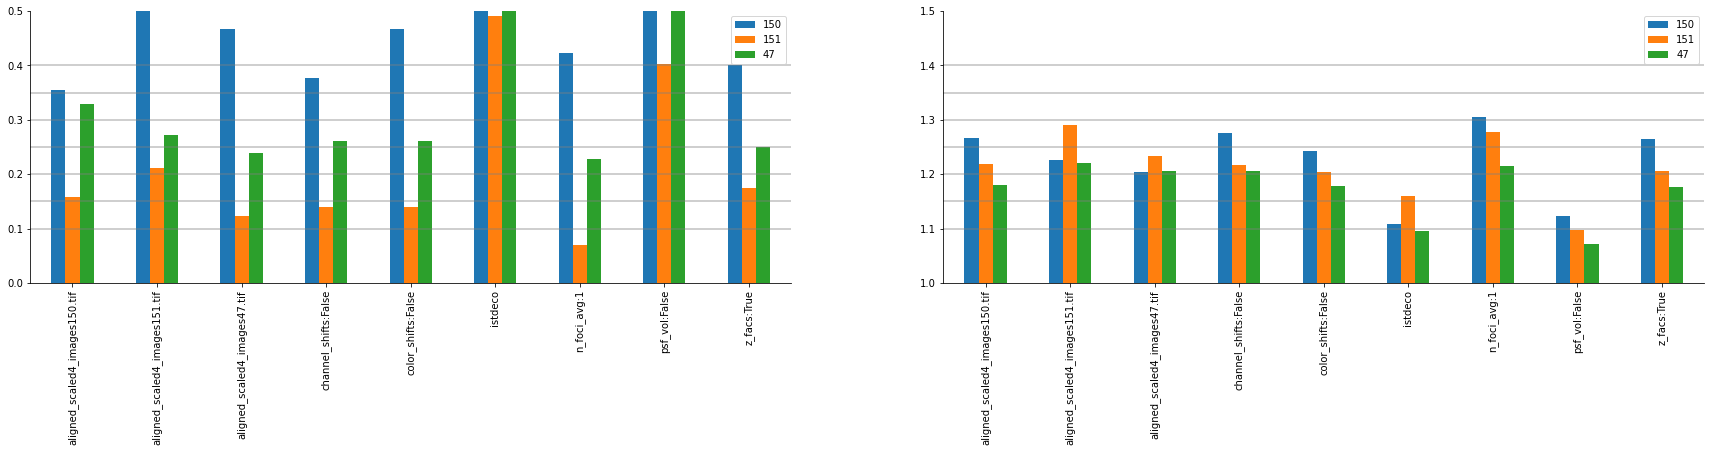

In [832]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
plot_df = omega_df.loc['NN_blanks'].unstack().T.astype(np.float32).drop('bench')
plot_df.plot.bar(ax=axes[0],stacked=False)
axes[0].plot([-0.5,len(omega_df.columns)/2],[1,1], color='red')
plot_df = omega_df.loc['NN'].unstack().T.astype(np.float32).drop('bench')
plot_df.plot.bar(ax=axes[1],stacked=False)
sns.despine()
axes[0].set_ylim(0,0.5)
for y in [0.1,0.15,0.2,0.25,0.3,0.35,0.4]:
    axes[0].plot([-0.5,len(omega_df.columns)/2],[y,y], color='gray', alpha=0.5)
    
axes[1].set_ylim(1,1.5)
for y in [1.1,1.15,1.2,1.25,1.3,1.35,1.4]:
    axes[1].plot([-0.5,len(omega_df.columns)/2],[y,y], color='gray', alpha=0.5)

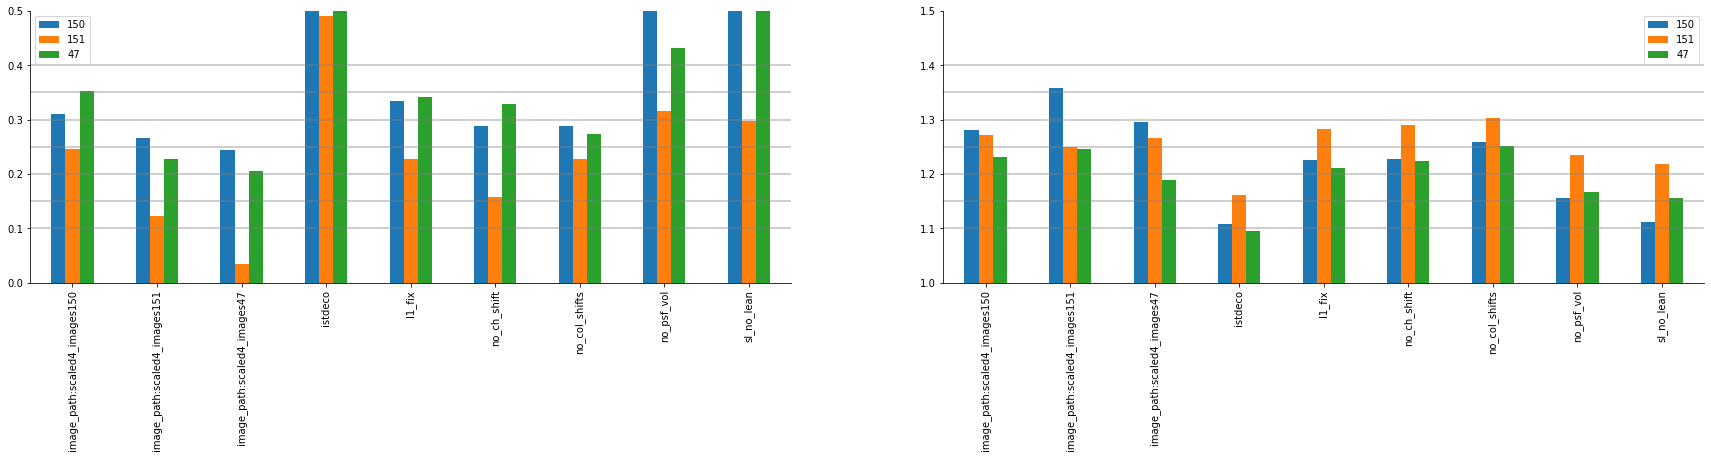

In [839]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
plot_df = omega_df.loc['NN_blanks'].unstack().T.astype(np.float32).drop('bench')
plot_df.plot.bar(ax=axes[0],stacked=False)
axes[0].plot([-0.5,len(omega_df.columns)/2],[1,1], color='red')
plot_df = omega_df.loc['NN'].unstack().T.astype(np.float32).drop('bench')
plot_df.plot.bar(ax=axes[1],stacked=False)
sns.despine()
axes[0].set_ylim(0,0.5)
for y in [0.1,0.15,0.2,0.25,0.3,0.35,0.4]:
    axes[0].plot([-0.5,len(omega_df.columns)/2],[y,y], color='gray', alpha=0.5)
    
axes[1].set_ylim(1,1.5)
for y in [1.1,1.15,1.2,1.25,1.3,1.35,1.4]:
    axes[1].plot([-0.5,len(omega_df.columns)/2],[y,y], color='gray', alpha=0.5)

(0.0, 1.0)

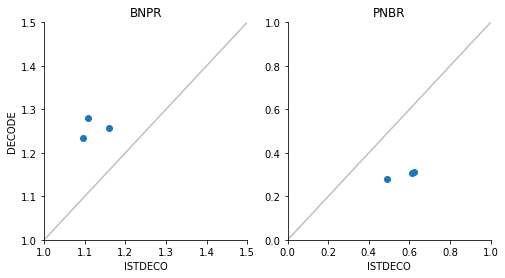

In [771]:
dec_n = 'image_path:scaled4_images150'
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(omega_df.loc['NN'].unstack()['istdeco'], omega_df.loc['NN'].unstack()[dec_n])
sns.despine()
plt.title('BNPR')
plt.xlabel('ISTDECO')
plt.ylabel('DECODE')
plt.plot([1.,1.5],[1.,1.5], color='gray', alpha=0.5)
plt.xlim(1,1.5)
plt.ylim(1,1.5)


plt.subplot(122)
plt.scatter(omega_df.loc['NN_blanks'].unstack()['istdeco'], omega_df.loc['NN_blanks'].unstack()[dec_n])
sns.despine()
plt.plot([0.,1.],[0.,1.], color='gray', alpha=0.5)
plt.title('PNBR')
plt.xlabel('ISTDECO')
plt.xlim(0,1)
plt.ylim(0,1)

In [840]:
df_dict['150'].keys()

dict_keys(['sl_no_lean', 'no_ch_shift', 'image_path:scaled4_images150', 'image_path:scaled4_images151', 'no_psf_vol', 'no_col_shifts', 'l1_fix', 'image_path:scaled4_images47'])

In [836]:
res1 = df_dict['150']['aligned_scaled4_images151.tif']

In [847]:
res2 = df_dict['150']['image_path:scaled4_images150']

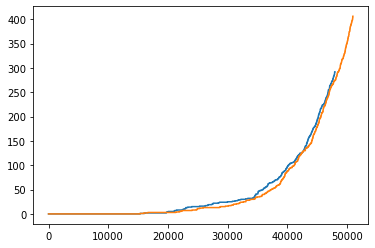

In [848]:
r  = make_roc(res1, 'int_ratio', ascending=True)
plt.plot(r, label=k)
r  = make_roc(res2, 'int_ratio', ascending=True)
plt.plot(r, label=k)

In [778]:
res_df = df_dict['150']['image_path:scaled4_images47']
# res_df = zero_int_ch(res_df, codebook)

In [774]:
pred_zeroed = zero_int_ch(res_df, codebook)
res_df['int_ratio'] = pred_zeroed['int_ratio'].values
res_df['tot_int'] = pred_zeroed['tot_int'].values
res_df['tot_int_0bit'] = pred_zeroed['tot_int_0bit'].values
res_df['tot_int_sig'] = pred_zeroed['tot_int_sig'].values

Text(0, 0.5, 'N Blanks')

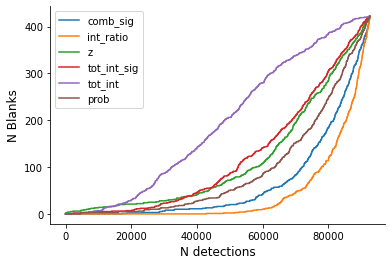

In [776]:
for k in ['comb_sig','int_ratio','z','tot_int_sig','tot_int','prob']:
    ascending = True if k not in ['prob' , 'tot_int'] else False
    r  = make_roc(res_df, k, ascending=ascending)
    plt.plot(r, label=k)
    
plt.legend()
sns.despine()

plt.xlabel('N detections', size=12)
plt.ylabel('N Blanks', size=12)

64213 64213


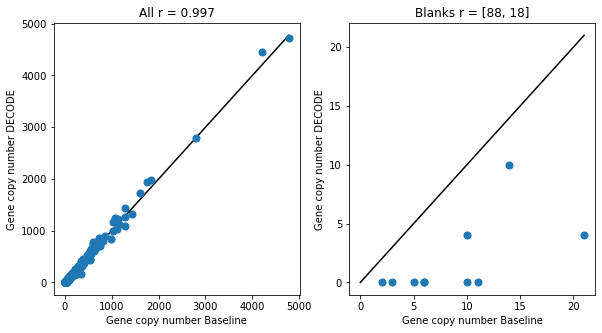

In [779]:
plot_gene_panels(res_df.nsmallest(len(bench_dfs['47']), 'int_ratio'), bench_dfs['47'], targets)

In [783]:
ist_df = istd_dfs['47'].nlargest(70000, 'quality')
dec_df = res_df.nsmallest(70000, 'int_ratio')
_,matches,shift = matching(ist_df, dec_df, tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.805
Precision: 0.805
Jaccard: 67.404
RMSE_vol: 69.841
Eff_3d: 52.230
FN: 13630.0 FP: 13630.0
Num. matches: 56370.000
Shift: 0.15,-5.11,2.60


Error rates

In [784]:
tps = dec_df.loc[dec_df['loc_idx'].isin(matches['loc_idx_pred'])]
fp_dec = dec_df.loc[~dec_df['loc_idx'].isin(matches['loc_idx_pred'])]
fp_istd = ist_df.loc[~ist_df['loc_idx'].isin(matches['loc_idx_tar'])]
print('Matched: ', np.round(tps['gene'].str.contains('Blank').sum(),2))
print('Pred by DECODE but not ISTDECO: ', np.round(fp_dec['gene'].str.contains('Blank').sum(),2))
print('Pred by ISTDECO but not DECODE: ', np.round(fp_istd['gene'].str.contains('Blank').sum(),2))

Matched:  3
Pred by DECODE but not ISTDECO:  42
Pred by ISTDECO but not DECODE:  84


In [798]:
par_dict = {}
par_dict['istdeco'] = [istd_dfs['150'], 'quality', False]
for i,k in enumerate(df_dict['150']):
    if len(df_dict['150'][k]) > 0:
        tra = sel_int_ch(df_dict['150'][k], codebook)
        par_dict[k] = [tra, 'int_ratio', True]

roc_dict = {}
for k in par_dict:
    y = make_roc(*par_dict[k])
    roc_dict[k] = y

In [799]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = np.arange(np.max([len(roc_dict[k]) for k in roc_dict]))
for k in roc_dict.keys():
    df.loc[:len(roc_dict[k])-1, k] = roc_dict[k]
    df[k] = pd.to_numeric(df[k], errors='coerce')
# df = pd.to_numeric(df, errors='coerce')

In [800]:
fig = px.line(df[::100], x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,90000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

Text(0, 0.5, 'N Blanks')

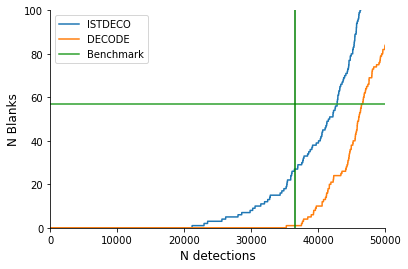

In [516]:
N_bench = len(bench_dfs['151'])
N_blanks_bench = bench_dfs['151']['class'].sum()

plt.plot(df['x'], df['istdeco'], label='ISTDECO')
plt.plot(df['x'], df['image_path:scaled4_images47'], label='DECODE')
plt.plot([0,85000], [N_blanks_bench,N_blanks_bench], label='Benchmark')
plt.plot([N_bench,N_bench], [0,100], color='green')
plt.xlim(0,50000)
plt.ylim(0,100)
plt.legend()
sns.despine()

plt.xlabel('N detections', size=12)
plt.ylabel('N Blanks', size=12)

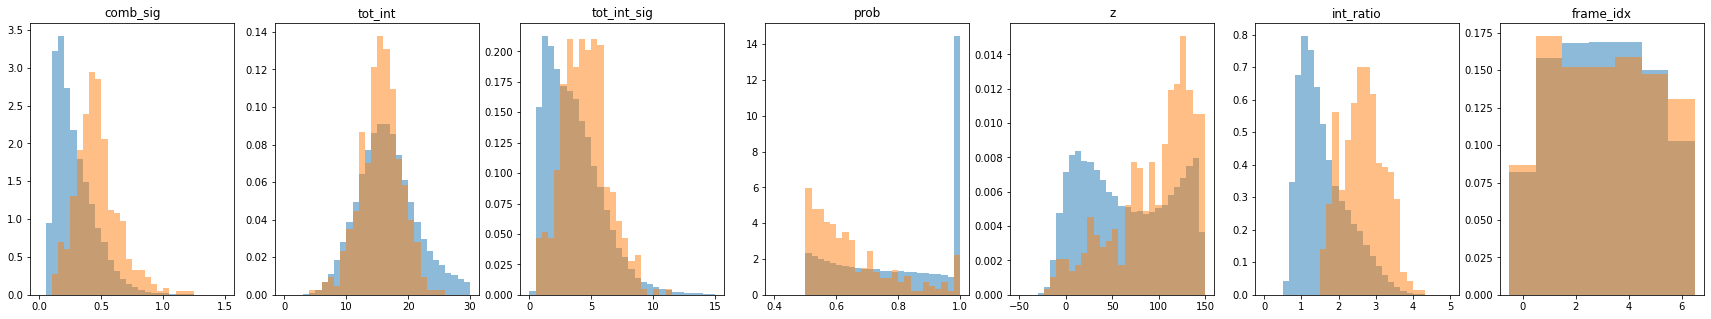

In [517]:
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z','int_ratio','frame_idx']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31), np.linspace(0,5.,31), np.linspace(-0.5,6.5,8)]
plt.figure(figsize=(30,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

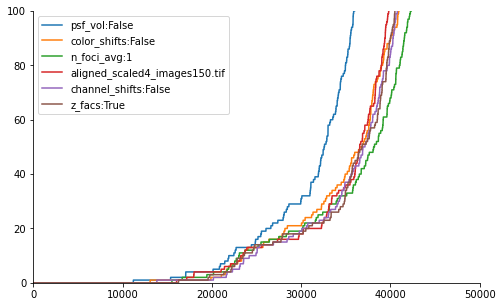

In [802]:
plt.figure(figsize=(8,5))
for n in df_dict['150']:
    if 'fix' not in n and '47' not in n and '151' not in n and 'istdeco' not in n:
        r  = make_roc(df_dict['150'][n], 'int_ratio', ascending=True)
        plt.plot(r, label=n)

plt.legend()
plt.ylim(0,100)
plt.xlim(0,50000)
sns.despine()

# Analyze blanks

In [550]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    f, x, y = coordinates
    crop = np.s_[f:f+1,:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [596]:
res_df = df_dict['151']['image_path:scaled4_images47']
res_df['int_ratio'] = zero_int_ch(res_df, codebook)['int_ratio']

In [587]:
img_stack = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images151.tif', z_to_batch=True)

6


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_19,int_sig_19,int_20,int_sig_20,int_21,int_sig_21,zm,gene,class,int_ratio
78643,111008,3,250,1194.4909,188.7492,0.383218,0.526438,14.973938,16.54259,24.81834,...,1.590579,0.23948,2.161261,0.328,1.357973,0.304279,38.321842,Blank-9,1,1.641512


(slice(3, 4, None), slice(None, None, None), slice(None, None, None), slice(182, 195, None), slice(1188, 1201, None))


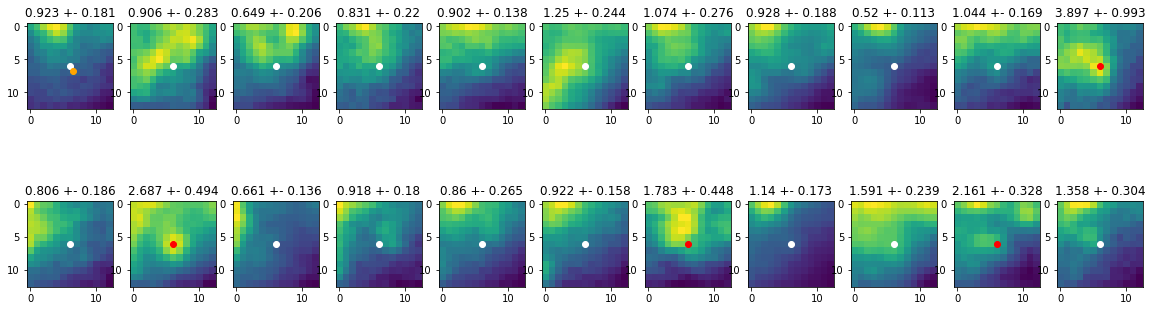

In [599]:
# Random predictions 
res_sub = res_df.nsmallest(40000, 'int_ratio')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, np.array(b_loc.loc[['frame_idx','x','y']].values, dtype='int32'), 6, 8)
crop = [crop[i] for i in [0,2,3,4]]

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_dfs['151']), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[0,i,0])
    color = 'red' if codebook[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')